In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
from torch.distributions import Categorical

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size = 256
lr = 1e-4

root = "../../datasets"

In [ ]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
test_transform = transforms.Compose([transforms.Resize(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])

train_dataset = Datasets.MNIST(root=root,
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = Datasets.MNIST(root=root,
                              train=False,
                              transform=test_transform,
                              download=True)

num_workers = os.cpu_count()
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=True)

In [ ]:
class VectorQuantizer(nn.Module):
  def __init__(self,
               code_book_size,
               latent_channels,
               commitment_cost):
    super().__init__()

    self.code_book_size = code_book_size
    self.latent_channels = latent_channels
    self.commitment_cost = commitment_cost

    self.embedding = nn.Embedding(code_book_size, latent_channels) # (code_book_size, latent_channels)
    self.embedding.weight.data.uniform_(-1 / code_book_size, 1 / code_book_size)

  def forward(self, inputs):
    # inputs shape: (batch_size, latent_channels, h, w)

    # Rearange the vector so that the last dimension is the same as the embedding vector
    inputs = inputs.permute(0, 2, 3, 1).contiguous() # (batch_size, latent_channels, h, w) -> (batch_size, h, w, latent_channels)
    input_shape = inputs.shape

    flat_input = inputs.view(-1, 1, self.latent_channels) # (batch_size, h, w, latent_channels) -> (batch_size * h * w, 1, latent_channels)

    # Calculate the distance between each input latent vector and each codebook vector, and compute the mean across the latent_channels

    # Embedding weight is (1, code_book_size, latent_channels), and broadcast across dimensions
    distances = (flat_input - self.embedding.weight.unsqueeze(0)).pow(2) # (batch_size * h * w, code_book_size, latent_channels)
    distances - distances.mean(2) # (batch_size * h * w, code_book_size)

    # Find the index of the closest codebook vector
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) # (batch_size * h * w, 1)

    # Find the embedding vector at the index using the look-up-table and reshape to image shape

    # Embedding look-up table gives output shape of: (batch_size * h * w, 1, latent_channels)
    quantized = self.embedding(encoding_indices).view(input_shape) # (batch_size, h, w, latent_channels)

    # Use detach to ensure that the gradient is not backpropagated through the codebook vectors

    # Codebook loss encourages the codebook vectors to move closer to the encoder outputs
    q_latent_loss = F.mse_loss(quantized, inputs.detach())

    # Encoder commitment loss encourages the encoder outputs to be close to their assigned codebook vectors
    e_latent_loss = F.mse_loss(quantized.detach(), inputs)

    # Weighted sum of losses
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    # During training, replace the quantized tensor with a version that is equal in the forward pass but allows gradients from the encoder to flow back.
    if self.training:
      # The quantization step is non-differentiable, which would normally block gradients.
      # Allows the network to update the encoder parameters even though the quantization is a discrete (non-differentiable) operation.
      quantized = inputs + (quantized - inputs).detach()
      # By adding this detached difference back to the original inputs, the overall output remains equal to quantized during the forward pass.

    # loss, (batch_size, latent_channels, h, w), (batch_size, h * w)
    return loss, quantized.permute(0, 3, 1, 2).contiguous(), encoding_indices.squeeze(dim=-1)

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, channels: int):
    super().__init__()

    self.norm_1 = nn.GroupNorm(8, channels)

    self.conv_1 = nn.Conv2d(in_channels=channels,
                           out_channels=channels,
                           kernel_size=3,
                           stride=1,
                           padding=1)

    self.norm_2 = nn.GroupNorm(8, channels)

    self.conv_2 = nn.Conv2d(in_channels=channels,
                           out_channels=channels,
                           kernel_size=3,
                           stride=1,
                           padding=1)

  def forward(self, x):
    # x shape: (batch_size, channels, h, w)
    skip = x

    x = F.elu(self.norm_1(x)) # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
    x = F.elu(self.norm_2(self.conv_1(x))) # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
    x = self.conv_2(x) + skip # (batch_size, channels, h, w)
    return x # (batch_size, channels, h, w)

class DownBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int):
      super().__init__()

      self.norm_1 = nn.GroupNorm(8, in_channels)

      self.conv_1 = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=3,
                              stride=2,
                              padding=1)

      self.norm_2 = nn.GroupNorm(8, out_channels)

      self.conv_2 = nn.Conv2d(in_channels=out_channels,
                              out_channels=out_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

      self.skip_conv = nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=3,
                                  stride=2,
                                  padding=1)

    def forward(self, x):
      # x shape: (batch_size, channels, h, w)
      x = F.elu(self.norm_1(x)) # (batch_size, channels, h, w) -> (batch_size, channels, h, w)

      x_skip = self.skip_conv(x) # (batch_size, channels, h, w) -> (batch_size, out_channels, h / 2, w / 2)

      x = F.elu(self.norm_2(self.conv_1(x))) # (batch_size, channels, h, w) -> (batch_size, out_channels, h / 2, w / 2)
      return self.conv_2(x) + x_skip # (batch_size, out_channels, h / 2, w / 2)

class UpBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int):
      super().__init__()

      self.norm_1 = nn.GroupNorm(8, in_channels)

      self.conv_1 = nn.Conv2d(in_channels=in_channels,
                              out_channels=in_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

      self.norm_2 = nn.GroupNorm(8, in_channels)

      self.conv_2 = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

      self.skip_conv = nn.Conv2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1)

      self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
      # x_in shape: (batch_size, channels, h, w)
      x = self.upsample(F.elu(self.norm_1(x_in))) # (batch_size, channels, h, w) -> (batch_size, channels, h * 2, w * 2)

      x_skip = self.skip_conv(x) # (batch_size, channels, h * 2, w * 2) -> (batch_size, out_channels, h * 2, w * 2)

      x = F.elu(self.norm_2(self.conv_1(x))) # (batch_size, channels, h * 2, w * 2) -> (batch_size, channels, h * 2, w * 2)
      return self.conv_2(x) + x_skip # (batch_size, out_channels, h * 2, w * 2)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,
               in_channels,
               ch=32,
               latent_channels=32):
    super().__init__()

    self.conv_in = nn.Conv2d(in_channels=in_channels,
                             out_channels=ch,
                             kernel_size=3,
                             stride=1,
                             padding=1)

    self.down_block_1 = DownBlock(in_channels=ch, out_channels=(ch * 2))
    self.down_block_2 = DownBlock(in_channels=(ch * 2), out_channels=(ch * 4))

    self.res_block_1 = ResBlock(channels=(ch * 4))
    self.res_block_2 = ResBlock(channels=(ch * 4))
    self.res_block_3 = ResBlock(channels=(ch * 4))

    self.conv_out = nn.Conv2d(in_channels=(4 * ch),
                              out_channels=latent_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

  def forward(self, x):
    # x shape: (batch_size, in_channels, h, w)
    x = self.conv_in(x) # (batch_size, in_channels, h, w) -> (batch_size, ch, h, w)

    x = self.down_block_1(x) # (batch_size, ch * 2, h, w) -> (batch_size, ch * 2, h / 2, w / 2)
    x = self.down_block_2(x) # (batch_size, ch * 4, h / 2, w / 2) -> (batch_size, ch * 4, h / 4, w / 4)

    x = self.res_block_1(x) # (batch_size, ch * 4, h / 4, w / 4) -> (batch_size, ch * 4, h / 4, w / 4)
    x = self.res_block_2(x) # (batch_size, ch * 4, h / 4, w / 4) -> (batch_size, ch * 4, h / 4, w / 4)
    x = F.elu(self.res_block_3(x)) # (batch_size, ch * 4, h / 4, w / 4) -> (batch_size, ch * 4, h / 4, w / 4)

    return self.conv_out(x) # (batch_size, ch * 4, h / 4, w / 4) -> (batch_size, latent_channels, h / 4, w / 4)

    # The output is the latent vector, where each image is represented by h * w discrete tokens (codebook vectors)
    # latent_channels is the size (or depth) of the vector at each spatial position in the latent grid. Each of these vectors is later quantized to a codebook vector of the same dimensionality.

class Decoder(nn.Module):
  def __init__(self,
               in_channels,
               ch=32,
               latent_channels=32):
    super().__init__()

    self.conv_in = nn.Conv2d(in_channels=latent_channels,
                             out_channels=(4 * ch),
                             kernel_size=3,
                             stride=1,
                             padding=1)

    self.res_block_1 = ResBlock(channels=(ch * 4))
    self.res_block_2 = ResBlock(channels=(ch * 4))
    self.res_block_2 = ResBlock(channels=(ch * 4))

    self.up_block_1 = UpBlock(in_channels=(4 * ch), out_channels=(2 * ch))
    self.up_block_2 = UpBlock(in_channels=(2 * ch), out_channels=ch)

    self.conv_out = nn.Conv2d(in_channels=ch,
                              out_channels=in_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)

  def forward(self, x):
    # x shape: (batch_size, latent_channels, h / 4, w / 4)
    x = self.conv_in(x) # (batch_size, latent_channels, h / 4, w / 4) -> (batch_size, 4 * ch, h / 4, w / 4)

    x = self.res_block_1(x) # (batch_size, 4 * ch, h / 4, w / 4) -> (batch_size, 4 * ch, h / 4, w / 4)
    x = self.res_block_2(x) # (batch_size, 4 * ch, h / 4, w / 4) -> (batch_size, 4 * ch, h / 4, w / 4)
    x = self.res_block_2(x) # (batch_size, 4 * ch, h / 4, w / 4) -> (batch_size, 4 * ch, h / 4, w / 4)

    x = self.up_block_1(x) # (batch_size, 4 * ch, h / 4, w / 4) -> (batch_size, 2 * ch, h / 2, w / 2)
    x = self.up_block_2(x) # (batch_size, 2 * ch, h / 2, w / 2) -> (batch_size, ch, h, w)

    return torch.tanh(self.conv_out(x)) # (batch_size, ch, h, w) -> (batch_size, channels, h, w)

In [ ]:
class VQVAE(nn.Module):
  def __init__(self,
               in_channels,
               ch=16,
               latent_channels=32,
               code_book_size=64,
               commitment_cost=0.25):
    super().__init__()

    self.encoder = Encoder(in_channels=in_channels,
                           ch=ch,
                           latent_channels=latent_channels)

    self.vq = VectorQuantizer(code_book_size=code_book_size,
                              latent_channels=latent_channels,
                              commitment_cost=commitment_cost)

    self.decoder = Decoder(in_channels=in_channels,
                           ch=ch,
                           latent_channels=latent_channels)

  def encode(self, x):
    encoding = self.encoder(x)
    vq_loss, quantized, encoding_indices = self.vq(encoding)
    return vq_loss, quantized, encoding_indices

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    vq_loss, quantized, encoding_indices = self.encode(x)
    recon = self.decode(quantized)

    return recon, vq_loss, quantized

In [ ]:
test_images = next(iter(test_dataloader))[0]
test_images.shape

torch.Size([256, 1, 32, 32])

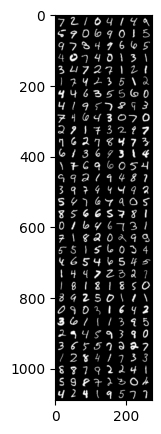

In [ ]:
plt.figure(figsize=(5, 5))
out = vutils.make_grid(test_images, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
code_book_size = 32
latent_channels = 10
epochs = 50

vae_net = VQVAE(in_channels=test_images.shape[1],
                latent_channels=latent_channels,
                ch=16,
                code_book_size=code_book_size,
                commitment_cost=0.25).to(device)

optimizer = optim.Adam(params=vae_net.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda')

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
train_loss = 0

In [ ]:
num_model_params = 0
for param in vae_net.parameters():
  num_model_params += param.flatten().shape[0]

print(f"The VQ-VAE Model Has {num_model_params} parameters")

The VQ-VAE Model Has 568251 parameters


In [ ]:
recon_data, vq_loss, quantized = vae_net(test_images.to(device))
quantized.shape

torch.Size([256, 10, 8, 8])

In [ ]:
pbar = trange(0, epochs, leave=False, desc="Epoch")

for epoch in pbar:
  train_loss = 0
  vae_net.train()

  for i, data in enumerate(tqdm(train_dataloader, leave=False, desc="Training")):
    image = data[0].to(device)

    with torch.amp.autocast("cuda"):
      recon_data, vq_loss, quantized = vae_net(image)

      # Calculate the loss
      recon_loss = (recon_data - image).pow(2).mean()
      loss = vq_loss + recon_loss

    # Take a training step
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Log the loss
    train_loss += recon_loss.item()

  lr_scheduler.step()
  pbar.set_postfix_str(f"Loss: {train_loss / len(train_dataloader)}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
vae_net.eval()
recon_data, vq_loss, quantized = vae_net(test_images.to(device))

In [ ]:
print(f"VQ Loss: {vq_loss}")

VQ Loss: 0.043863095343112946


In [ ]:
_, _, encoding_indices = vae_net.encode(test_images.to(device))

In [ ]:
encoding_indices[0]

tensor(27, device='cuda:0')

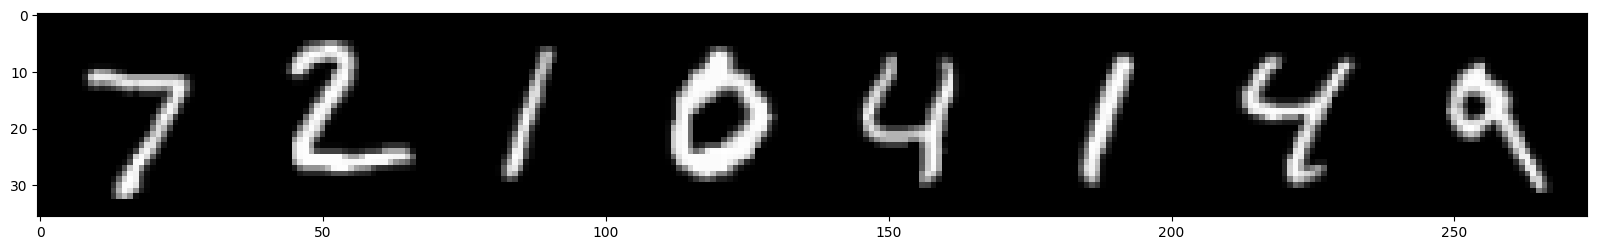

In [ ]:
plt.figure(figsize=(20, 10))
out = vutils.make_grid(test_images[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

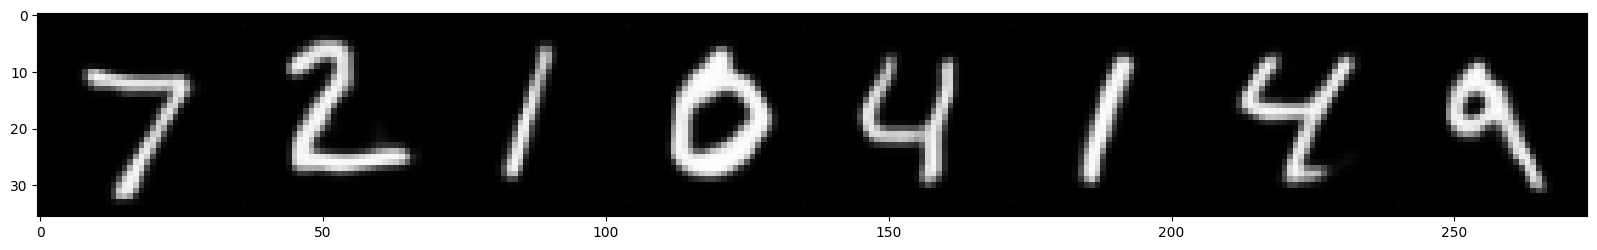

In [ ]:
plt.figure(figsize=(20, 10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
plt.figure(figsize=(20, 10))
out = vutils.make_grid(quantized[:, 0, :, :].unsqueeze(dim=1).detach().cpu()[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
class SinusoidalPosEmb(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model

  def forward(self, x):
    device = x.device
    half_dim = self.d_model // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = x[:, None] * emb[None, :]
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

In [ ]:
class Encoder(nn.Module):
  def __init__(self, d_model=128, num_layers=3, num_heads=4):
    super().__init__()

    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                               nhead=num_heads,
                                               dim_feedforward=(d_model * 4),
                                               dropout=0.0,
                                               batch_first=True)

    self.encoder_layers = nn.TransformerEncoder(encoder_layer, num_layers)

  def forward(self, input_seq, padding_mask=None):
    batch_size, seq_len, d_model = input_seq.shape

    # Make a target mask so that each position in the sequence can only attend to previous positions and itself
    target_mask = torch.triu(torch.ones(seq_len, seq_len, device=input_seq.device), 1).bool()

    output = self.encoder_layers(src=input_seq, mask=target_mask)

    return output

In [ ]:
class Transformer(nn.Module):
  def __init__(self,
               num_emb,
               d_model=128,
               num_layers=3,
               num_heads=4):
    super().__init__()

    # Embedding layer for tokens
    self.embedding = nn.Embedding(num_emb, d_model) # (num_emb, d_model) -> (code_book_size + 1, d_model)

    # Sinusoidal positional embeddings
    self.pos_emb = SinusoidalPosEmb(d_model)

    self.encoder = Encoder(d_model=d_model,
                           num_layers=num_layers,
                           num_heads=num_heads)

    self.fc_out = nn.Linear(in_features=d_model, out_features=num_emb)

  def embed(self, input_seq):
    # Embed the input sequence
    input_embs = self.embedding(input_seq) # (batch_size, seq_len, d_model)
    batch_size, seq_len, d_model = input_embs.shape

    # Add positional embeddings to the input embeddings
    seq_indx = torch.arange(seq_len, device=input_seq.device)
    pos_emb = self.pos_emb(seq_indx).reshape(1, seq_len, v).expand(batch_size, seq_len, d_model)
    embs = input_embs + pos_emb

    return embs

  def forward(self, input_seq):
    # input_seq shape: (batch_size, seq_len)
    embeded_seq = self.embed(input_seq) # (batch_size, seq_len, d_model)
    encoded_seq = self.encoder(embeded_seq) # (batch_size, seq_len, d_model)

    return self.fc_out(encoded_seq)  # (batch_size, seq_len, num_emb)

In [ ]:
num_layers = 4
num_heads = 8
d_model = 256
epochs = 100

tf_generator = Transformer(num_emb=code_book_size + 1, # code_book_size + 1 to make room for sos token at the beginning of the sequence
                           num_layers=num_layers,
                           d_model=d_model,
                           num_heads=num_heads).to(device)

tf_optimizer = optim.Adam(params=tf_generator.parameters(), lr=lr)
tf_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(tf_optimizer, T_max=epochs, eta_min=0)
tf_scaler = torch.amp.GradScaler("cuda")
loss_fn = nn.CrossEntropyLoss()

In [ ]:
num_model_params = 0
for param in tf_generator.parameters():
  num_model_params += param.flatten().shape[0]

print(f"The TF Model Has {num_model_params} parameters.")

The TF Model Has 3175969 parameters.


In [ ]:
pbar = trange(0, epochs, leave=False, desc="Epoch")
vae_net.eval()

for epoch in pbar:
  train_loss = 0

  tf_generator.train()
  for i, data in enumerate(tqdm(train_dataloader, leave=False, desc="Training")):
    image = data[0].to(device) # (batch_size, c, h, w)

    with torch.inference_mode():
      # Get the discrete indices for vectors in the codebook
      # These will be the target sequence for the transformer
      _, _, encoding_indices = vae_net.encode(image) # encoding_indices shape: (batch_size * h * w)

    batch_size = image.size(0)
    encoding_indices = encoding_indices.view(batch_size, -1) # Flatten the encoding_indices (batch_size, h * w)

    # Shift indices by 1 for start-of-sequence token
    # The original indices range from 0 to code_book_size - 1. By adding 1, we reserve the token 0 as a special start-of-sequence marker.
    encoding_indices = encoding_indices + 1

    # Make a start token, append it to the beginning, and get rid of the last token which we will be predicting
    tf_inputs = torch.cat((torch.zeros_like(encoding_indices[:, 0:1]), encoding_indices[:, :-1]), 1) # (batch_size, h * w)
    tf_outputs = encoding_indices # (batch_size, h * w)

    # Generate predictions
    with torch.amp.autocast("cuda"):
      pred = tf_generator(tf_inputs) # (batch_size, h * w, num_emb)

    loss = loss_fn(pred.permute(0, 2, 1), tf_outputs)

    # Backpropagation
    tf_optimizer.zero_grad()
    tf_scaler.scale(loss).backward()
    tf_scaler.step(tf_optimizer)
    tf_scaler.update()

    # Log training loss and entropy
    train_loss += loss.item()

  tf_lr_scheduler.step()
  pbar.set_postfix_str(f"Loss: {train_loss / len(train_dataloader)}")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
temp = 0.99
log_tokens = [torch.zeros(64, 1).long()] # (batch_size=64, 1) 64 sequences starting with 0 for sos token

tf_generator.eval()

with torch.inference_mode():
  for i in range(64): # Do for every h' x w'
    # Concatenate tokens from previous iterations along the 2nd dimension
    input_tokens = torch.cat(log_tokens, 1)

    # Get model predictions for the next token
    data_pred = tf_generator(input_tokens.to(device)) # (64, seq_len=(i + 1), num_emb=(code_book_size + 1))

    # Sample the last token from the probability distribution
    dist = Categorical(logits=data_pred[:, -1] / temp)
    next_tokens = dist.sample().reshape(-1, 1) # (64, 1, 1) -> (64, 1)

    log_tokens.append(next_tokens.cpu())

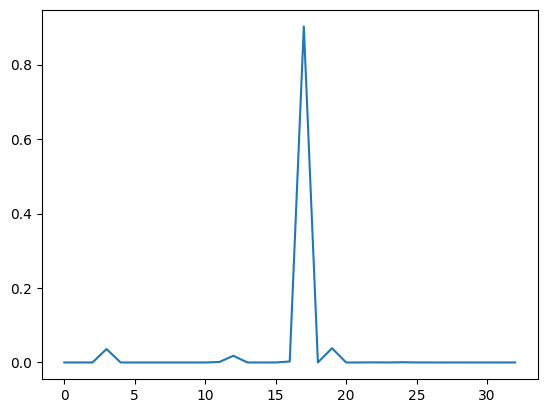

In [ ]:
plt.plot(F.softmax(data_pred[0, -1], -1).flatten().cpu())

In [ ]:
embs_indx = torch.cat(log_tokens, 1)[:, 1:].to(device) - 1 # (64, 64)
embeds = vae_net.vq.embedding(embs_indx) # (64, 64, latent_channels)
embeds = embeds.reshape(-1, 8, 8, latent_channels).permute(0, 3, 1, 2).contiguous() # (64, latent_channels, 8, 8)

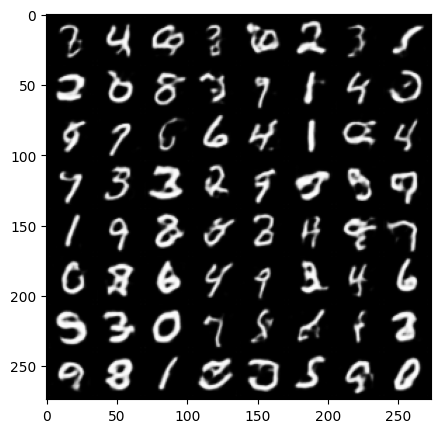

In [ ]:
# Take the latent embeddings and reconstructs the original image
recon_data = vae_net.decode(embeds) # (64, 3, h, w)

plt.figure(figsize=(5, 5))
out = vutils.make_grid(recon_data.detach().cpu(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

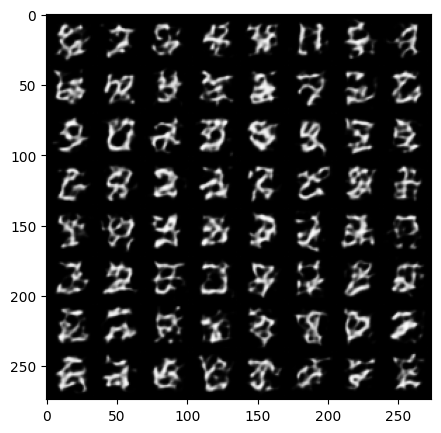

In [ ]:
# Random sequence of discrete tokens (latent indicies for the codebook) for each sequence in the batch
rand_sample = torch.randint(code_book_size, (64, 64), device=device) # (64, 64)

# Get the vector from the codebook at each index
rand_sample_embeds = vae_net.vq.embedding(rand_sample).reshape(-1, 8, 8, latent_channels).permute(0, 3, 1, 2).contiguous() # (64, latent_channels, 8, 8)

recon_data = vae_net.decode(rand_sample_embeds) # (64, 3, h, w)

plt.figure(figsize=(5, 5))
out = vutils.make_grid(recon_data.detach().cpu(), normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))